In [19]:
from models.inference_pipeline import CCTAPipeline
from models.unet3D import UNet3D, dice_bce_loss
from models.net_utils import calculate_jaccard_score, calculate_dice_score
import torch
from models.net_utils import get_best_device
from server_specific.server_utils import get_patients
from data.data_utils import divide_3d_image_into_patches
import numpy as np

In [20]:
device = get_best_device()

torch.set_default_device(device)
print(f"Using {device} device. Every tensor created will be by default on {device}")


model = UNet3D(in_channels=1, num_classes=1)

trained_model_path = "saved_models/3d_model20241119-163629.pth"

model.load_state_dict(torch.load(trained_model_path, weights_only=True))
model.to(device)
model.eval()

Using cuda device. Every tensor created will be by default on cuda


UNet3D(
  (down_convolution_1): DownSample(
    (conv): DoubleConv3D(
      (conv_op): Sequential(
        (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): ReLU(inplace=True)
        (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (3): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
    )
    (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_convolution_2): DownSample(
    (conv): DoubleConv3D(
      (conv_op): Sequential(
        (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): ReLU(inplace=True)
        (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (3): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
    )
    (pool): MaxPool3d(kern

In [21]:
print("-----INFERENCE_______")

patients = get_patients()
patients = np.array(patients)

test_patients = patients[700:]

print("Test dataset:", test_patients.shape)

-----INFERENCE_______
amt of detected_files:  1800
amt of patients:  800
Test dataset: (100,)


In [22]:
ccta_pipeline = CCTAPipeline(model, block_size=64)

In [6]:
test_ccta_scan, test_ccta_mask = test_patients[1].get_image_mask_tuple()

prediction = ccta_pipeline(test_ccta_scan)

(256, 512, 512)


In [7]:
print(prediction.shape)

(241, 512, 512)


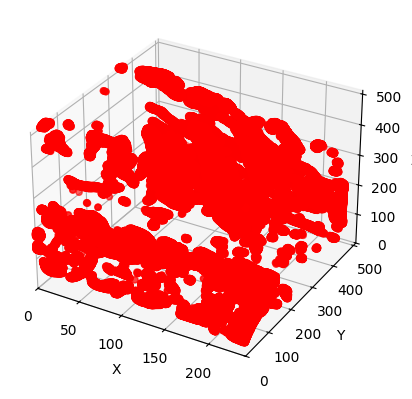

In [8]:
from data_generation.generate_3d import visualize3Dimage

visualize3Dimage(prediction)

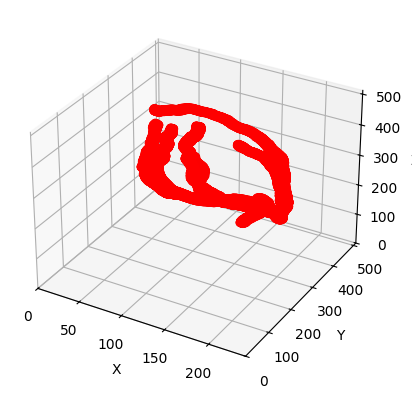

In [9]:
visualize3Dimage(test_ccta_mask)

In [10]:
# loss = dice_bce_loss(prediction, test_ccta_mask).item()
jaccard = calculate_jaccard_score(prediction, test_ccta_mask)
print(jaccard)

dice = calculate_dice_score(prediction, test_ccta_mask)
print(dice)

0.08673156748408946
0.15961911861064856


In [25]:
amt_of_test_patients = 10

average_jaccard = 0
average_dice = 0

for patient_idx in range(amt_of_test_patients):
    print(f"processing patient {patient_idx + 1} / {amt_of_test_patients}")
    test_ccta_scan, test_ccta_mask = test_patients[patient_idx].get_image_mask_tuple()

    prediction = ccta_pipeline(test_ccta_scan)
    jaccard = calculate_jaccard_score(prediction, test_ccta_mask)
    average_jaccard += jaccard
    print(jaccard)

    dice = calculate_dice_score(prediction, test_ccta_mask)
    average_dice += dice
    print(dice)

average_jaccard /= amt_of_test_patients
average_dice /= amt_of_test_patients

print(f"average jaccard: {average_jaccard}")
print(f"average dice: {average_dice}")

processing patient 1 / 10
(320, 512, 512)
0.116101793131294
0.20804875298258071
processing patient 2 / 10
(256, 512, 512)
0.08673156748408946
0.15961911861064856
processing patient 3 / 10
(256, 512, 512)
0.0861614417971554
0.15865310345503197
processing patient 4 / 10
(320, 512, 512)
0.04721990422077059
0.09018144905468849
processing patient 5 / 10
(256, 512, 512)
0.1319786261471594
0.23318218754070702
processing patient 6 / 10
(256, 512, 512)
0.07868697611203682
0.14589399493011784
processing patient 7 / 10
(320, 512, 512)
0.06319002289405974
0.1188687281358287
processing patient 8 / 10
(320, 512, 512)
0.15488416950420217
0.2682245953214421
processing patient 9 / 10
(320, 512, 512)
0.03332795793578816
0.06450606059738333
processing patient 10 / 10
(320, 512, 512)
0.06015271500059314
0.11347933962619618
average jaccard: 0.08584351742271487
average dice: 0.1560657330254625


In [12]:
prediction_patches = divide_3d_image_into_patches(prediction[0:192,:,:], block_shape=(64,64,64))

In [13]:
prediction_patches.shape

(3, 8, 8, 64, 64, 64)

In [15]:
smaller_mask = test_ccta_mask[0:192]
smaller_pred = prediction[0:192]

In [16]:
prediction_patches = divide_3d_image_into_patches(smaller_pred, block_shape=(64,64,64))
mask_patches = divide_3d_image_into_patches(smaller_mask, block_shape=(64,64,64))

In [17]:
patches_amt = prediction_patches.shape[0] * prediction_patches.shape[1] * prediction_patches.shape[2]
print(f"amt of prediction patches: {patches_amt}")

amt of prediction patches: 192


skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch


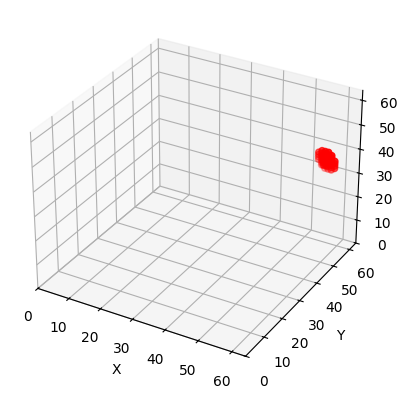

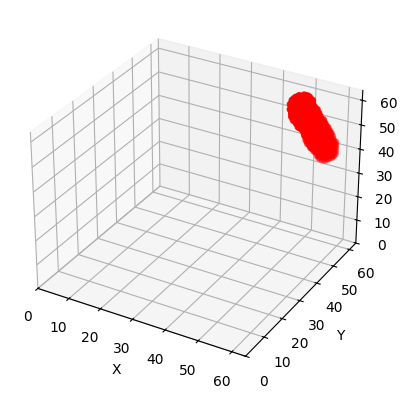

skipping patch


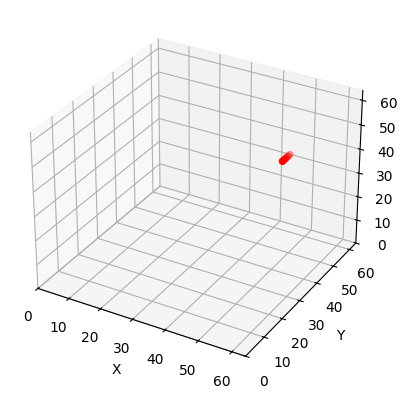

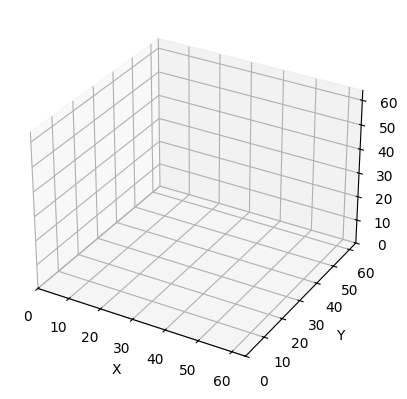

skipping patch
skipping patch
skipping patch
skipping patch


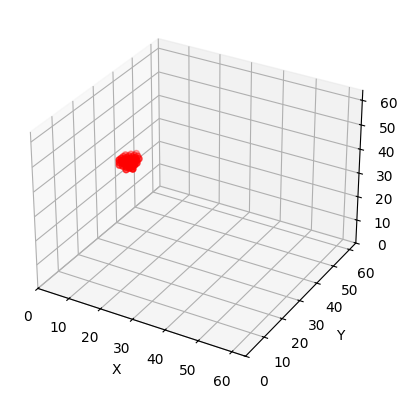

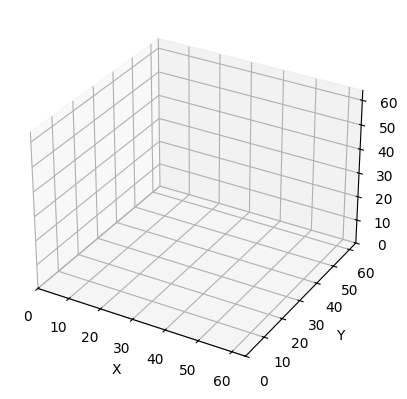

skipping patch
skipping patch
skipping patch
skipping patch
skipping patch


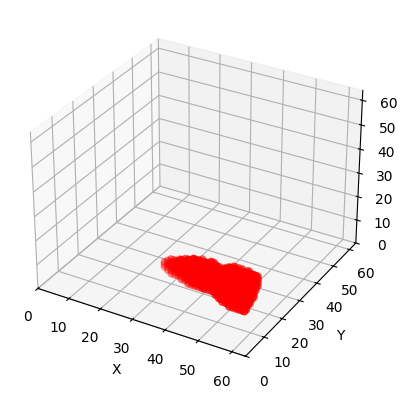

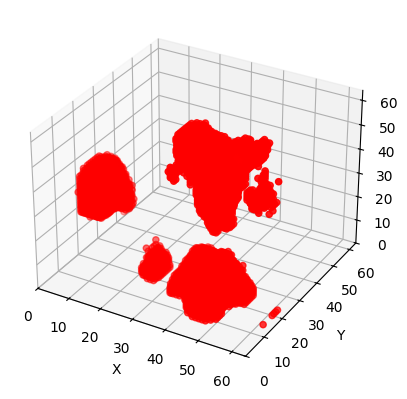

skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch


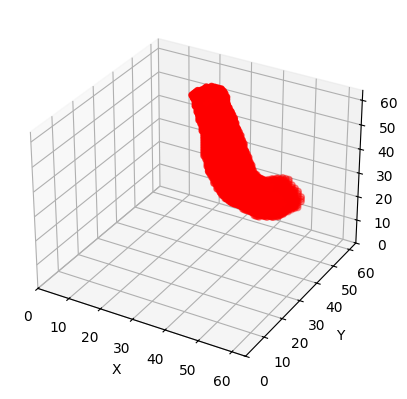

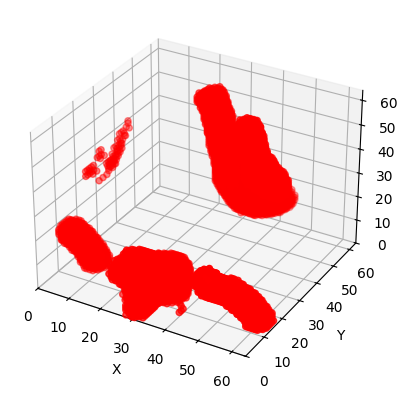

skipping patch


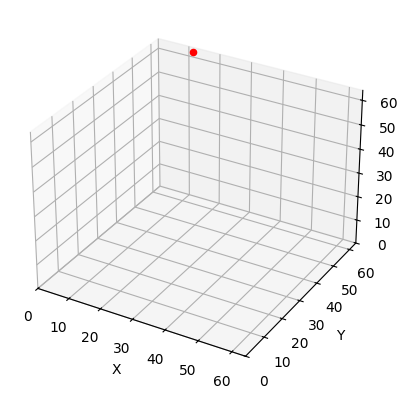

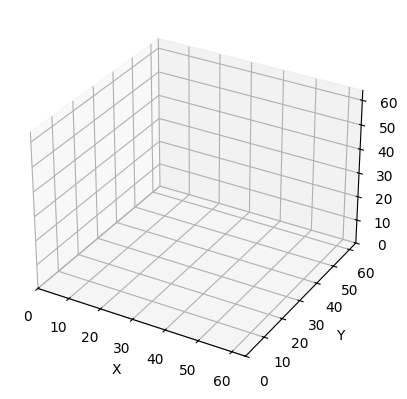

skipping patch


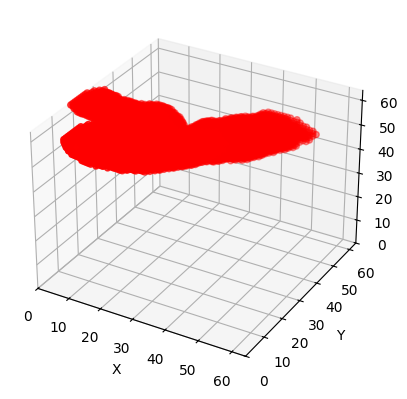

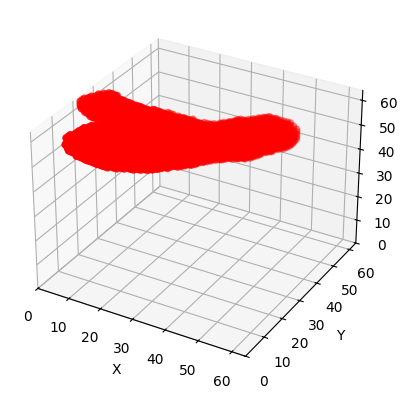

skipping patch


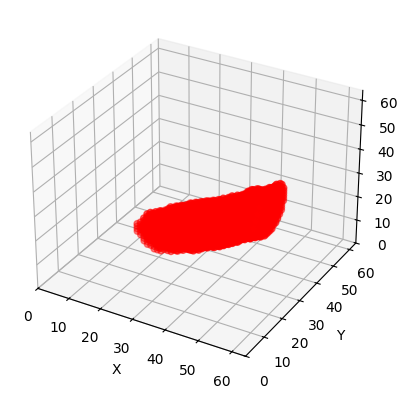

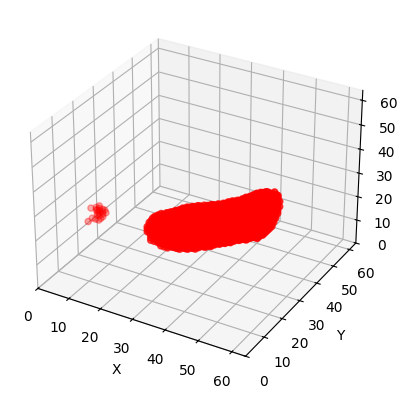

skipping patch
skipping patch
skipping patch
skipping patch
skipping patch


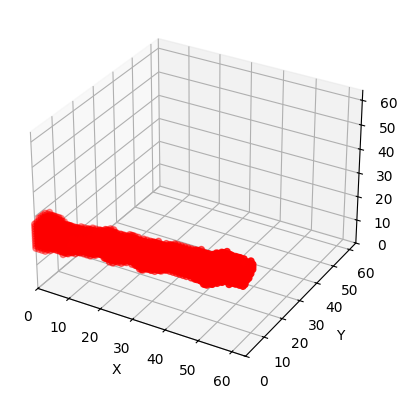

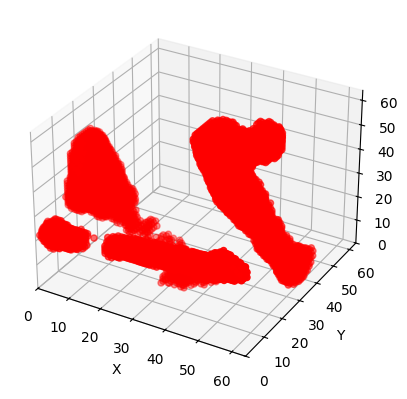

skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch


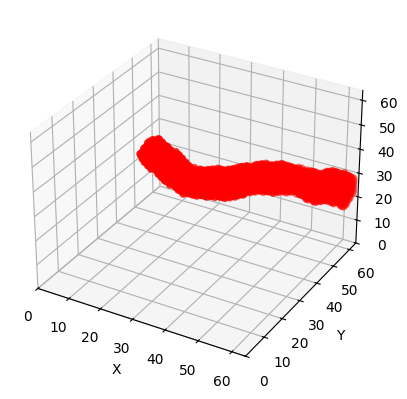

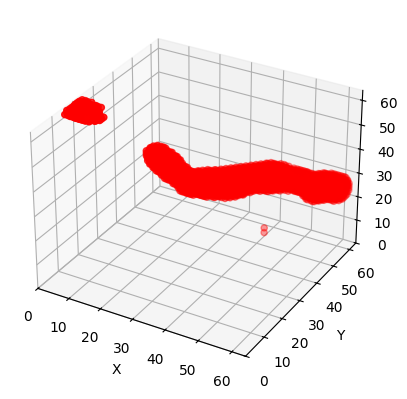

skipping patch
skipping patch
skipping patch
skipping patch


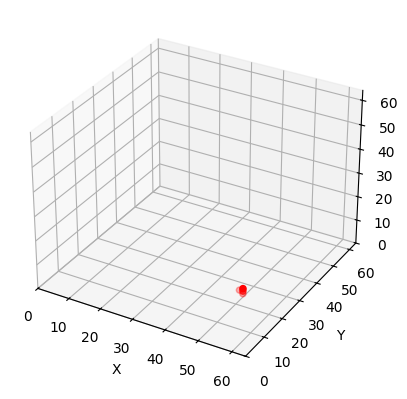

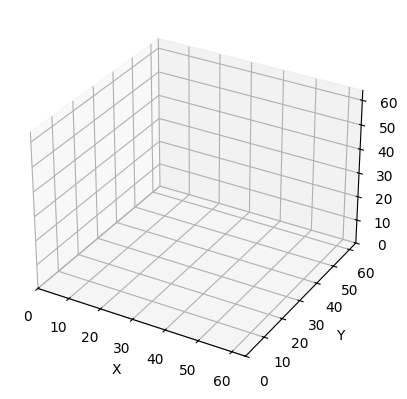

skipping patch
skipping patch
skipping patch
skipping patch
skipping patch


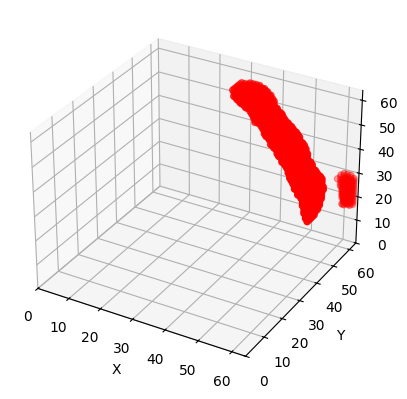

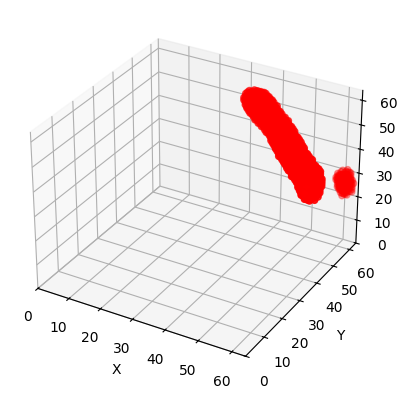

skipping patch


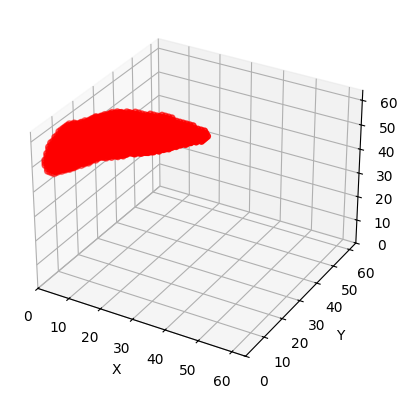

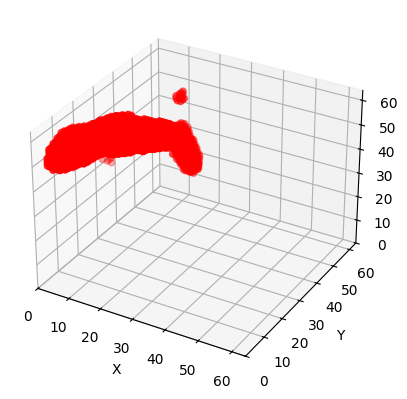

skipping patch
skipping patch


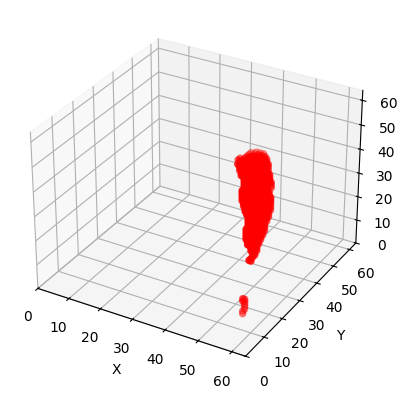

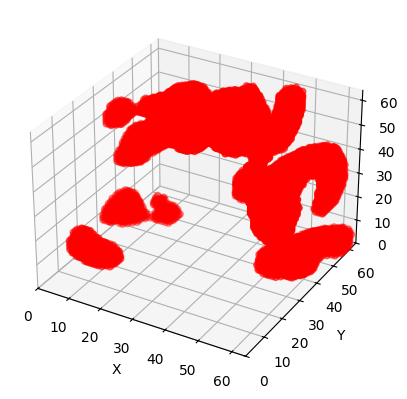

skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch
skipping patch


In [18]:
patch_counter = 0
patch_shape = prediction_patches.shape
for i in range(patch_shape[0]):
    for j in range(patch_shape[1]):
        for k in range(patch_shape[2]):
            patch_counter += 1
            current_mask_patch = mask_patches[i,j,k]
            
            
            if np.all(current_mask_patch == 0):
                    print("skipping patch")
                    continue
            
            current_pred_patch = prediction_patches[i,j,k]
            visualize3Dimage(current_mask_patch)
            visualize3Dimage(current_pred_patch)
            break

In [ ]:
patch_counter = 0
patch_shape = prediction_patches.shape
for i in range(patch_shape[0]):
    for j in range(patch_shape[1]):
        for k in range(patch_shape[2]):
            patch_counter += 1
            current_mask_patch = mask_patches[i,j,k]
            
            
            if np.all(current_mask_patch == 1):
                    print("skipping patch")
                    continue
            
            current_pred_patch = prediction_patches[i,j,k]
            # visualize3Dimage(current_mask_patch)
            visualize3Dimage(current_pred_patch)
            break